<a href="https://colab.research.google.com/github/xu-pu/colab-notebooks/blob/master/scipy_integrators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ODE Integrators from Scipy

In [1]:
import sympy
sympy.init_printing()

# Derive the Equations of Motion

In [33]:
t, l, g, m, ddq = sympy.symbols('t l g m \ddot{q}')
q = sympy.Function('q')(t)
dq = sympy.Function('\dot{q}')(t)
q, dq, ddq, m, l, g, t

In [34]:
x = l * sympy.sin(q)
y = - l * sympy.cos(q)

rules = [
    (q.diff(t), dq),
    (dq.diff(t), ddq)
]

dx = x.diff(t).subs(rules)
dy = y.diff(t).subs(rules)

Construct the Lagrangian

In [4]:
T = sympy.S.Half * m * ( dx**2 + dy**2 )
V = m * g * y
L = T-V
L = sympy.simplify(L)
L

Construct Energy $\mathcal{H}$

In [37]:
H = T+V
H = sympy.simplify(H)
H

Construct the Euler-Lagrange Equation

In [5]:
eq = L.diff(dq).diff(t) - L.diff(q)
eq = eq.subs(rules)
eq = sympy.simplify(eq)
eq

In [6]:
ans = sympy.solve(eq, ddq)
assert(len(ans) == 1)
sol = ans[0]
sol

In [7]:
eom = sympy.lambdify([q, l, g], sol)
??eom

In [8]:
eom(0.1,1,9.8)

# Numerical Simulation

In [9]:
import scipy
from scipy.integrate import solve_ivp
import numpy as np

In [10]:
def get_system_equation(l, g=9.8):
  def ode_func(t, y):
    return np.array([
      y[1],
      eom(y[0],l,g)
  ])
  return ode_func

In [25]:
fps = 25
duration = 5
frames = fps * duration
interval = 1000 / fps
length = 1

results = solve_ivp(
    get_system_equation(length), 
    (0,duration), 
    (np.pi/6,0),
    t_eval = np.linspace(0,duration,duration*fps)
)

vt = results.t
results.y.shape
vq = results.y[0,:]
vdq = results.y[1,:]
vx = sympy.lambdify([l,q], x)(length, vq)
vy = sympy.lambdify([l,q], y)(length, vq)

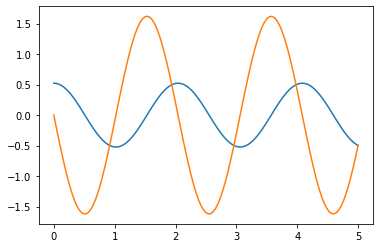

In [26]:
import matplotlib.pyplot as plt
plt.plot(vt,vq)
plt.plot(vt,vdq)
plt.show()

Plot Energy

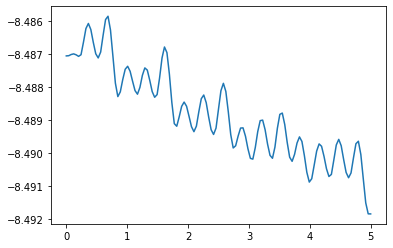

In [42]:
ve = sympy.lambdify([l,m,g,q,dq], H)(length, 1, 9.8, vq, vdq)
plt.plot(vt,ve)
plt.show()

In [43]:
# Animation

%matplotlib inline

from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_aspect('equal')
ax.set_xlim(( -2, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=1, marker="o")

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    line.set_data([0,vx[i]], [0,vy[i]])
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=interval, blit=True)
plt.close()

# frames is i, interval is ms between frames

HTML(anim.to_jshtml())